In [3]:
import math
import pandas as pd
import numpy as np
import numpy
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [4]:
data_NSE = yf.download("^NSEI", start="2013-05-01", end="2023-05-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [5]:
def refine_data(series_data, smooth=12):
    smooth_data = series_data.rolling(window = smooth).mean().dropna()

    local_max = argrelextrema(smooth_data.values, np.greater)[0]
    local_min = argrelextrema(smooth_data.values, np.less)[0]

    return smooth_data, local_max, local_min

In [6]:
def head_and_shoulders(data_Close, pct_change=0.01, head_pct=0.012):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_min = np.delete(local_min, 0)
    else:
        local_min = np.delete(local_min, len(local_min) - 1)

    local_min = smooth_data[local_min]
    local_max = smooth_data[local_max]

    heads = []
    shoulders = []
    for i in range(2, min(len(local_max), len(local_min))):
        if (local_max[i] < local_max[i-2]*(1+pct_change) and local_max[i] > local_max[i-2]*(1-pct_change)) and (local_max[i-1] > local_max[i]*(1+head_pct) or local_max[i-1] > local_max[i-2]*(1+head_pct)):
            heads.append(local_max.index[i-1])
            shoulders.append(local_max.index[i-2])
            shoulders.append(local_max.index[i])

    return heads, shoulders

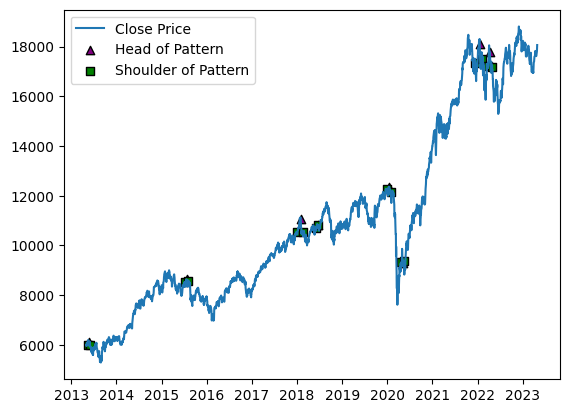

In [25]:
head, shoulder = head_and_shoulders(data_NSE.Close, 0.01, 0.01)

plt.plot(data_NSE.index, data_NSE.Close)
plt.scatter(head, data_NSE.Close[head], color='purple', marker='^', edgecolors='black', linewidths=1, label='Head of Pattern')
plt.scatter(shoulder, data_NSE.Close[shoulder], color='green', marker='s', edgecolors='black', linewidths=1, label='Shoulder of Pattern')

plt.legend(["Close Price", "Head of Pattern", "Shoulder of Pattern"])

plt.show()

In [7]:
def ascending_triangle(data_Close, pct_change=0.05):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_max = np.delete(local_max, len(local_max) - 1)
    else:
        local_max = np.delete(local_max, 0)

    extremes = np.concatenate((local_min, local_max))
    extremes.sort()
    extremes = smooth_data[extremes]

    pattern = 0 
    triangle = []
    for i in range(2, len(extremes), 2):
        if (extremes[i-2] > extremes[i]*(1+pct_change)) and (extremes[i-1] < extremes[i+1]*(1+pct_change) and extremes[i-1] > extremes[i+1]*(1-pct_change)):
            if pattern == 0:
                triangle.append([extremes.index[i-2], extremes.index[i-1]])
                pattern = 1
        else:
            if pattern == 1:
                triangle[-1].append(extremes.index[i-2])
                triangle[-1].append(extremes.index[i-1])
                pattern = 0

    if len(triangle[-1]) == 2:
        triangle.remove(triangle[-1])

    return triangle, smooth_data

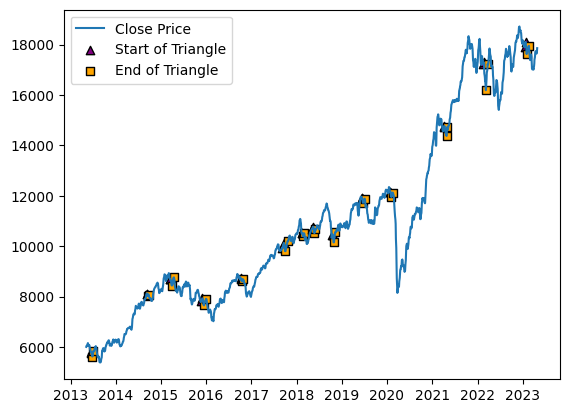

In [26]:
flags, data = ascending_triangle(data_NSE.Close, 0.01)
plt.plot(data.index, data)

for x in flags:
    plt.scatter(x[0:2], data[x[0:2]], color='purple', marker='^', edgecolors='black', linewidths=1, label='Start of Triangle')
    plt.scatter(x[2:], data[x[2:]], color='orange', marker='s', edgecolors='black', linewidths=1, label='End of Triangle')

plt.legend(["Close Price", "Start of Triangle", "End of Triangle"])

plt.show()

In [8]:
def bear_flag(data_Close, pct_change=0.05):
    smooth_data, local_max, local_min = refine_data(data_Close, 5)
    if (local_max[0] > local_min[0]):
        local_max = np.delete(local_max, len(local_max) - 1)
    else:
        local_max = np.delete(local_max, 0)

    extremes = np.concatenate((local_min, local_max))
    extremes.sort()
    extremes = smooth_data[extremes]

    pattern = 0 
    flag = []
    for i in range(2, len(extremes), 2):
        if (extremes[i-2] < extremes[i]*(1+pct_change) and extremes[i-2] > extremes[i]*(1-pct_change)) and (extremes[i-1] < extremes[i+1]*(1+pct_change) and extremes[i-1] > extremes[i+1]*(1-pct_change)):
            if pattern == 0:
                flag.append([extremes.index[i-2], extremes.index[i-1]])
                pattern = 1
        else:
            if pattern == 1:
                flag[-1].append(extremes.index[i-2])
                flag[-1].append(extremes.index[i-1])
                pattern = 0

    if len(flag[-1]) == 2:
        flag.remove(flag[-1])

    return flag, smooth_data

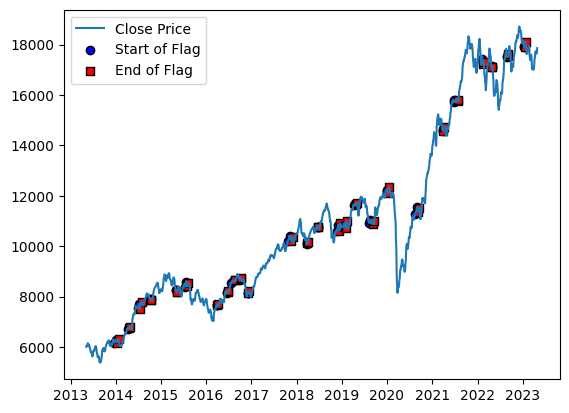

In [28]:
flags, data = bear_flag(data_NSE.Close, 0.01)
plt.plot(data.index, data)

for x in flags:
    plt.scatter(x[0:2], data[x[0:2]], color='blue', marker='o', edgecolors='black', linewidths=1, label='Start of Flag')
    plt.scatter(x[2:], data[x[2:]], color='red', marker='s', edgecolors='black', linewidths=1, label='End of Flag')

plt.legend(["Close Price", "Start of Flag", "End of Flag"])

plt.show()

In [9]:
def rounding_top(data_Close, window=100):
    pattern = []

    for i in range(0, len(data_Close)-100, 100):
        data = data_Close[i: i+100]

        # PolyFit
        x = np.linspace(1, len(data), len(data))
        pol = np.polyfit(x, data, np.sqrt(len(data))*2)
        y_pol = np.polyval(pol, x)
        
        # Getting all Local minimas using prev thing
        smooth_data, local_max, local_min = refine_data(pd.Series(y_pol), 5)
        data = data[len(data) - len(smooth_data): ]
        for x in local_max:
            pattern.append(data.index[x])

    return pattern

C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipykernel_18756\1933730928.py:1: RankWarning: Polyfit may be poorly conditioned
  rb_ptrn = rounding_top(data_NSE.Close, 200)
C:\Users\himma\AppData\Local\Temp\ipyker

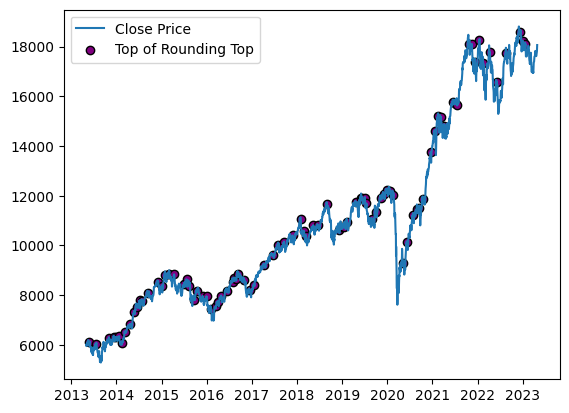

In [29]:
rb_ptrn = rounding_top(data_NSE.Close, 200)

plt.plot(data_NSE.index, data_NSE.Close)
plt.scatter(rb_ptrn, data_NSE.Close[rb_ptrn], color='purple', marker='o', edgecolors='black', linewidths=1, label='Top of Rounding Top')
plt.legend(["Close Price", "Top of Rounding Top"])

plt.show()